# HW11 - Descriptive Notebook

Note: Updated, to remove flattening in trainer function.

In this homework notebook, we will create a Wasserstein GAN with Convolution and Transpose Convolution layers, to be used on the MNIST dataset.

Get familiar with the code and write a small report (2 pages max), with answers to the questions listed at the end of the notebook.

**The report must be submitted in PDF format, before April 18th, 11.59pm!**

Do not forget to write your name and student ID on the report.

You may also submit your own copy of the notebook along with the report. If you do so, please add your name and ID to the cell below.

In [1]:
# Name: Phang Teng Fone
# Student ID: 1003296

### Imports needed

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch import Tensor
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import save_image

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Dataset and dataloader

In [4]:
# Image transform to be applied to dataset
# - Tensor conversion
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
# MNIST train dataset
mnist = torchvision.datasets.MNIST(root = './data/',
                                   train = True,
                                   transform = transform,
                                   download = True)

In [6]:
# Data loader
batch_size = 32
data_loader = torch.utils.data.DataLoader(dataset = mnist,
                                          batch_size = batch_size, 
                                          shuffle = True)

### Critic model as a set of Conv2d layers

**Task1:** Rewrite the Critic model below, so that it uses Conv2d layers instead of fully connected ones shown in class.

You may look for inspiration in the encoder models used in Notebook 3 (W11S1 lecture).

The critic should use three Conv2d layers with progressive downsampling.

We do not advise to add more layers to the mix (BatchNorm, Dropout, etc.).

In [86]:
# Critic
class Critic(nn.Module):
    
    def __init__(self, image_size):
        """
        Only forced parameter will be the image size, set to 28.
        n = batch size,c = channel,h = height,w = width, in is 28
        """
        super().__init__()
        self.D = nn.Sequential(nn.Conv2d(1,16, 6, stride = 3, padding = 0),
                                     nn.LeakyReLU(0.2),
                                     nn.Conv2d(16, 32, 4, stride = 3, padding = 1),
                                     nn.LeakyReLU(0.2),
                                     nn.Conv2d(32, 1, 4,stride = 2, padding = 1 )
                               )
        
    def forward(self, x):
        x = self.D(x)
        return x

### Generator model as a set of Transposed Conv2d layers

**Task2:** Rewrite the Generator model below, so that it uses Transposed Conv2d layers instead of fully connected ones shown in class.

You may look for inspiration in the encoder models used in Notebooks 2 and 3 (W11S1 lecture).

The critic should use three Transposed Conv2d layers with progressive upsampling.

We do not advise to add more layers to the mix (BatchNorm, Dropout, etc.).

In [87]:
# Generator 
class Generator(nn.Module):
    
    def __init__(self, latent_size, image_size):
        """
        Only forced parameters will be the image size, set to 28,
        and the latent size set to 64. 
        output should be = batchsize, 1 , 28,28
        input dimension(32,64,1,1)
        """
        super().__init__()
        self.G = nn.Sequential(nn.ConvTranspose2d(latent_size, 32, 7 , stride = 1),
                nn.LeakyReLU(0.2),
                nn.ConvTranspose2d(32, 16, 3, stride = 2,output_padding = 1, padding = 1),
                nn.LeakyReLU(0.2),
                nn.ConvTranspose2d(16, 1, 3, stride = 2,output_padding = 1, padding = 1),
                nn.LeakyReLU(0.2)
                )

    def forward(self, x):
        x = self.G(x)
        return x

### Trainer function

**Task 3:** Decide on a number of iterations num_epochs for training!

In [77]:
# Hyperparameters for model generation and training
latent_size = 64
image_size = 28
num_epochs = 50
batch_size = 32

In [78]:
# Create discriminator model
f = Critic(image_size)
f.to(device)

Critic(
  (D): Sequential(
    (0): Conv2d(1, 16, kernel_size=(6, 6), stride=(3, 3))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [79]:
# Create generator model
G = Generator(latent_size, image_size)
G.to(device)

Generator(
  (G): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
  )
)

In [80]:
# Losses and optimizers
# d_optimizer = torch.optim.Adam(f.parameters(), lr = 0.0002)
# g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002)
d_optimizer = torch.optim.RMSprop(f.parameters(), lr = 0.00005)
g_optimizer = torch.optim.RMSprop(G.parameters(), lr = 0.00005)

In [81]:
# History trackers for training curves
# Keeping track of losses
d_losses = np.zeros(num_epochs)
g_losses = np.zeros(num_epochs)

**Note: running the cell below (our trainer function) will take a long time!**

In [82]:
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        
        # 1. Send image to device
        images = Variable(images, requires_grad = True).to(device)
        
        
        """
        PART 1: TRAIN THE CRITIC
        """

        # 2. Compute mean of critic decisions using real images
        outputs_real = f(images)
        
        # 2.bis. Compute mean of critic decisions using fake images
        z = torch.randn(batch_size, latent_size,1,1).to(device)
        z = Variable(z)

        fake_images = G(z)
        outputs_fake = f(fake_images)
        
        # 3. Compute gradient regularization
        real_grad_out = Variable(Tensor(images.size(0), 1,1,1).fill_(1.0), requires_grad = False).to(device)
        real_grad = autograd.grad(outputs_real, images, real_grad_out, create_graph = True, \
                                  retain_graph = True, only_inputs = True)[0]
        real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1)**3
        fake_grad_out = Variable(Tensor(fake_images.size(0), 1,1,1).fill_(1.0), requires_grad = False).to(device)
        fake_grad = autograd.grad(outputs_fake, fake_images, fake_grad_out, create_graph = True, \
                                  retain_graph = True, only_inputs = True)[0]
        fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1)**3
        reg_term = torch.mean(real_grad_norm + fake_grad_norm)
        
        # 4. Backprop and optimize for f
        # Loss is simply the difference between means, plus regularization term
        # Remember to reset gradients for both optimizers!
        d_loss = -torch.mean(outputs_real) + torch.mean(outputs_fake) + reg_term
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 4.bis. Optional, weight clipping on critic
        # (Mentioned in WGAN paper)
        for p in f.parameters():
            p.data.clamp_(-0.01, 0.01)
        
        
        """
        PART 2: TRAIN THE GENERATOR
        """
        
        for k in range(0,5):
            # 5. Generate fresh noise samples and produce fake images
            z = torch.randn(batch_size, latent_size,1,1).cuda()
            z = Variable(z)
            fake_images = G(z)
            outputs = f(fake_images)

            # 6. Loss for G
            g_loss = - torch.mean(outputs)

            # 7. Backprop and optimize G
            # Remember to reset gradients for both optimizers!
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
        
        
        """
        PART 3: UPDATE STATISTICS FOR VISUALIZATION LATER
        """
        
        # 8. Update the losses and scores for mini-batches
        d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) \
            + d_loss.item()*(1./(i+1.))
        g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) \
            + g_loss.item()*(1./(i+1.))
        
        # 9. Display
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item()))

Epoch [0/50], Step [200/1875], d_loss: -0.0046, g_loss: -0.0007
Epoch [0/50], Step [400/1875], d_loss: -0.0008, g_loss: 0.0100
Epoch [0/50], Step [600/1875], d_loss: -0.0007, g_loss: 0.0078
Epoch [0/50], Step [800/1875], d_loss: -0.0005, g_loss: 0.0087
Epoch [0/50], Step [1000/1875], d_loss: -0.0003, g_loss: 0.0089
Epoch [0/50], Step [1200/1875], d_loss: -0.0005, g_loss: 0.0089
Epoch [0/50], Step [1400/1875], d_loss: -0.0005, g_loss: 0.0080
Epoch [0/50], Step [1600/1875], d_loss: -0.0001, g_loss: 0.0077
Epoch [0/50], Step [1800/1875], d_loss: -0.0002, g_loss: 0.0085
Epoch [1/50], Step [200/1875], d_loss: -0.0006, g_loss: 0.0081
Epoch [1/50], Step [400/1875], d_loss: -0.0002, g_loss: 0.0075
Epoch [1/50], Step [600/1875], d_loss: -0.0004, g_loss: 0.0079
Epoch [1/50], Step [800/1875], d_loss: -0.0004, g_loss: 0.0072
Epoch [1/50], Step [1000/1875], d_loss: -0.0004, g_loss: 0.0081
Epoch [1/50], Step [1200/1875], d_loss: -0.0004, g_loss: 0.0083
Epoch [1/50], Step [1400/1875], d_loss: -0.0004

### Visualization

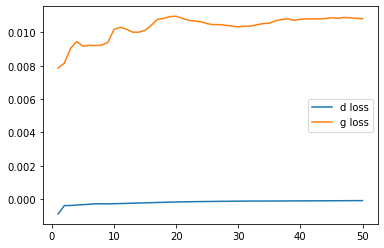

In [83]:
# Display losses for both the generator and discriminator
plt.figure()
plt.plot(range(1, num_epochs + 1), d_losses, label = 'd loss')
plt.plot(range(1, num_epochs + 1), g_losses, label = 'g loss')    
plt.legend()
plt.show()

In [84]:
# Generate a few fake samples (5 of them) for visualization
n_samples = 5
z = torch.randn(n_samples, latent_size,1,1).cuda()
z = Variable(z)
fake_images = G(z)
fake_images = fake_images.cpu().detach().numpy().reshape(n_samples, 28, 28)
print(fake_images.shape)

(5, 28, 28)


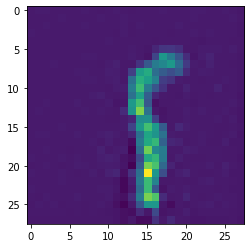

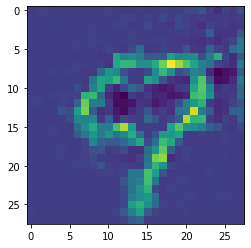

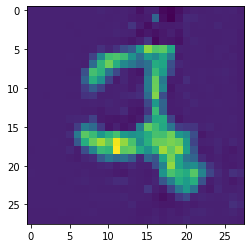

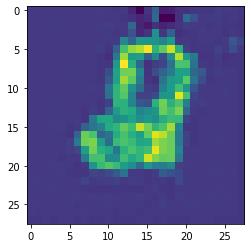

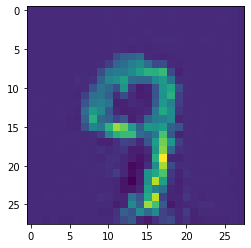

In [85]:
# Display
plt.figure()
plt.imshow(fake_images[0])
plt.show()
plt.figure()
plt.imshow(fake_images[1])
plt.show()
plt.figure()
plt.imshow(fake_images[2])
plt.show()
plt.figure()
plt.imshow(fake_images[3])
plt.show()
plt.figure()
plt.imshow(fake_images[4])
plt.show()

### Questions and expected answers for the report

1. Copy and paste the code for your Critic class. Briefly explain your choice of architecture.


2. Copy and paste the code for your Generator class. Briefly explain your choice of architecture.


3. For how many iterations did you have to train when using Wasserstein with Conv/TransposeConv layers to get plausible images from the generator? Is it training faster than the Fully Connected Wasserstein/Vanilla GAN?


4. Display some samples generated by your trained generator. Do they look plausible?


5. Let us assume we use Conv2d layers in the Critic. We do NOT use Transposed Conv2d layers, but only Fully Connected layers in the Generator. Would the GAN still be able to train both models or would it encounter difficulties? Discuss.